# Лабораторная 4: Классификаторы

> Разработка классификаторов: _Логистическая регрессия_, _Дерево решений_ и _Random forest_.

Используемые библиотеки (включая собственные классификаторы):

In [1]:
import numpy   as np
import pandas  as pd

from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import OneHotEncoder, LabelEncoder
from sklearn.metrics         import confusion_matrix, ConfusionMatrixDisplay

from classifiers.logistic_regression import LogisticRegression
from classifiers.trees import CART, RandomForest

data_folder = "data/" # Папка хранения данных

### Обработка данных

Описание обработки данных содержится в предыдущем отчете, а здесь будет только повтор действий.
Если потребуется какая-либо дополнительная обработка, она будет расписана.

In [2]:
# Load wine data

wines = pd.read_csv(data_folder + "winequality-red.csv")
wines = wines.drop(columns=["fixed acidity", "citric acid", "total sulfur dioxide", "density"])
wines["quality"] = wines["quality"].apply(lambda x : 1 if x >= 6 else 0)
X, y = wines.iloc[:, :-1], wines.iloc[:, -1]

W_X_train, W_X_test, W_y_train, W_y_test = train_test_split(X.values, y.values, test_size=0.3)

# Load cars data

cars = pd.read_csv(data_folder + "cars/car.data")
X, y = cars.iloc[:, :-1], cars.iloc[:, -1]
C_X_train, C_X_test, C_y_train, C_y_test = train_test_split(X.values, y.values, test_size=0.3)

Во всех задачах классификации будет потребовано, чтобы датасет с машинами был закодирован:

In [3]:
C_X_encoder = OneHotEncoder(categories='auto', drop=None, sparse=False)
C_y_encoder = LabelEncoder()

C_X_train = C_X_encoder.fit_transform(C_X_train)
C_y_train = C_y_encoder.fit_transform(C_y_train)

C_X_test = C_X_encoder.transform(C_X_test)
C_y_test = C_y_encoder.transform(C_y_test)

Следующая функция будет использована для оценки точности классификаторов:

In [4]:
def test_classifier(classifer, X_train, X_test, y_train, y_test):
    classifer.fit(X_train, y_train)
    y_predict = classifer.predict(X_test)
    print(f"Accuracy is {(y_predict == y_test).mean()}")
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_predict)).plot()

## Логистическая регрессия

Логистическая регрессия может быть (если задача классификации) 
и бинарной, и многоклассовой, но здесь внимание отводится на
задачу бинарной классификации.

В центре логистической регрессии лежит функция гипотезы:

$$
h(z) = \frac{1}{1 + \exp(-z)}
$$

где $z$ - вектор взвешенных особенностей: $z = \theta x$

Если ошибку рассматривать как отклонение от реального класса для множества
особенностей, то формульно это задать как квадрат отклонения:

$$
J(z, y) = \frac{1}{2m}\sum_{i = 1}^{m}(h(z_i) - y_i)^2
$$

где $m$ - размер образца (кол-во пар особенности - класс),
$y_i$ - корректная классификация $i$-го образца.

Для этой функции нужно найти argmin, но в таком формате этой будет трудно,
так как итоговая функция - невыпуклая, с локальными минимумами. Для
логистической регрессии используется особая форма функции ошибок:

$$
J(z, y) = -\frac{1}{m} \sum_{i = 1}^{m} \left[y_i \log(h(z_i)) + (1 - y_i) \log(1 - h(z_i))\right]
$$

Функция сходится к минимуму методом градиентного спуска по формуле:

$$
\theta_j = \theta_j - \alpha \frac{ \partial J }{ \partial \theta_j }
$$

где $\theta_j$ - вес соответствующий особенности $x_j$, $\alpha$ - скорость обучения 
(задается пользователем, обычно $\alpha = 0.01$).

После подсчета производной получается формула:

$$
\frac{ \partial J }{ \partial \theta_j } = \frac{1}{m} \sum_{i = 1}^{m} (y_i - h(z_i)) x_j
$$

### Собственная реализация

В `classfier.logistic_regression` в классе `LogisticRegression` содержится реализация 
описанного выше алгоритма:

Accuracy is 0.725
CPU times: user 3.13 s, sys: 19.8 ms, total: 3.15 s
Wall time: 3.15 s


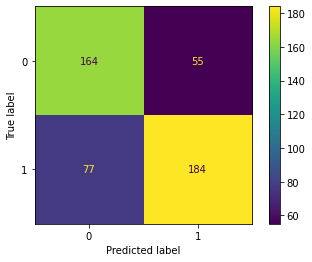

In [5]:
custom_lr = LogisticRegression(0.01, 100000)
custom_lr.fit = custom_lr.train
%time test_classifier(custom_lr, W_X_train, W_X_test, W_y_train, W_y_test)

Точность логистического регрессора: $72.5\%$, что выше собственного алгоритма на $1.9\%$, 
причем изменение скорости почти не заметно. Такой алгортм более подходящий, особенно 
учитывая, что он заточен на бинарную классификацию.

### Реализация `sklearn`

Стандартно в регрессии от `sklearn` имеется дополнительная регуляризация для
предотвращения переобучения, но, т.к. в собственной реализации её нет, сравнения
ради она отключена:

Accuracy is 0.7270833333333333
CPU times: user 63 ms, sys: 0 ns, total: 63 ms
Wall time: 62.1 ms


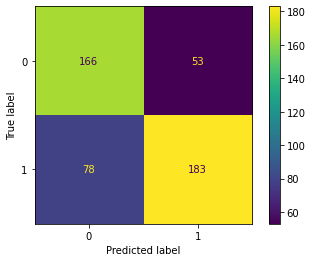

In [6]:
ski_lr = linear_model.LogisticRegression('none')
%time test_classifier(ski_lr, W_X_train, W_X_test, W_y_train, W_y_test)

Точность больше на $0.2\%$, но это не учитывая количество итераций: в то время, как такая точность была 
достигнута за 100000 в собственной реализации, в `sklearn` она была достигнута (судя по документации)
за 100 итераций, а сам регрессор был в сотни раз быстрее.

## Дерево решений

Построенное вручную дерево решений просто представляет собой дерево, 
в каждой вершине кроме листьев в которой задается вопрос по какому-либо свойству
и определяется следующая вершина в зависимости от ответа. В листьях же содержится
возможная классификация на основе свойств.

При построении дерева решений используется функция определения количества полученной
информации, но перед её введением следует ввести формулу оценки "загрязненности" вершины.

Вершина считается загрязненной, если (считая ее листом) в ней в качестве ответа содержится
много разных классов, т.е. пройдясь по дереву классификации и дойдя до этой вершины,
особенности могут быть классифицированы не одним, а двумя, тремя и более классами. Тогда
вершина считается загрязненной ("impure").

Формульно это можно оценить с помощью коэффициента Джини:

$$
G = 1 - \sum_{i=1}^{n}p_i^2
$$

где $p_i$ - вероятность класса $i$ в вершине. 

Например, если вершина состоит целиком из одного класса, то его вероятность $p_i = 1$, а коэффициент Джини соответственно равен $G = 1 - 1^2 = 0$ (вершина чистая). 
Если же в вершине 2 класса `a`, 1 класс `b` и 2 класса `c`, то их вероятности 
соответственно $p_a = \frac{2}{5}, p_b = \frac{1}{5}, p_c = \frac{2}{5}$, 
а коэффициент Джини 
$G = 1 - \left(\left(\frac{2}{5}\right)^2 + \left(\frac{1}{5}\right)^2 + \left(\frac{2}{5}\right)^2\right) = 0.64$, соответственно вершина грязная.

Тогда коэффициент получения информации можно определить как разницу между загрязнением
родительской вершины и итоговым загрязнением детей, причем они умножены на коэффициенты,
равные проценту отшедших в них классов. Подробнее на примере: пусть коэффициент Джини
у родителя 0.65 и в нем 5 классов. После деления, например в левого ребенка отошло 2
класса, а его коэффициент 0.3, и в правого ребенка отошло 3 оставшихся класса, а его 
коэффициент 0.25. Тогда полученная информация:

$$
I = 0.65 - \left(\frac{2}{5}0.3 + \frac{3}{5}0.25\right) = 0.38
$$

Для нахождения лучшего деления необходимо делить образцы 
относительно каждого значения каждой особенности (т.е. на те, которые удовлетворяют
значению, и те, которые не удовлетворяют), и создать детские вершины с этими
разбиениями. Лучшее деление будет иметь максимальную полученную информацию $I$.

Существуют разные алгоритмы деления, но здесь был описан алгоритм `CART` 
(Classification And Regression Tree).

### Собственная реализация

Приведенный выше алгоритм в `classifier.trees` в `CART`. Проверка дерева на датасете с вином:

Accuracy is 0.75
CPU times: user 871 ms, sys: 3.17 ms, total: 874 ms
Wall time: 876 ms


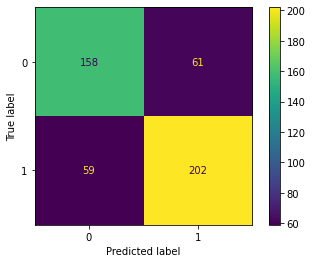

In [7]:
custom_tree = CART()
custom_tree.fit = custom_tree.train
%time test_classifier(custom_tree, W_X_train, W_X_test, W_y_train, W_y_test)

По скорости деревья оказались значительно быстрее логистического регрессора и при этом точность больше.
Кроме того, класс `1` был идентифицирован значительно лучше, чем у регрессора.

Для датасета с машинами:

Accuracy is 0.9865125240847784
CPU times: user 138 ms, sys: 0 ns, total: 138 ms
Wall time: 137 ms


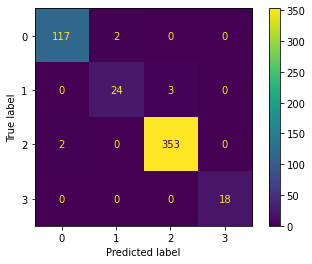

In [8]:
custom_tree = CART()
custom_tree.fit = custom_tree.train
%time test_classifier(custom_tree, C_X_train, C_X_test, C_y_train, C_y_test)

Матрица ошибок показывает незначительные неточности.

### Реализация `sklearn`

Для вина:

Accuracy is 0.74375
CPU times: user 38.6 ms, sys: 0 ns, total: 38.6 ms
Wall time: 38.1 ms


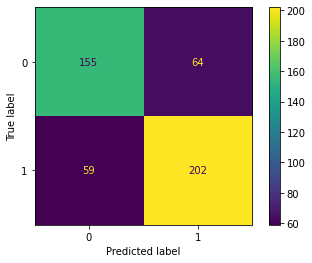

In [9]:
ski_tree = tree.DecisionTreeClassifier()
%time test_classifier(ski_tree, W_X_train, W_X_test, W_y_train, W_y_test)

Точность примерно одинакова, но скорость значительно выше.

Accuracy is 0.976878612716763
CPU times: user 44.5 ms, sys: 0 ns, total: 44.5 ms
Wall time: 43.7 ms


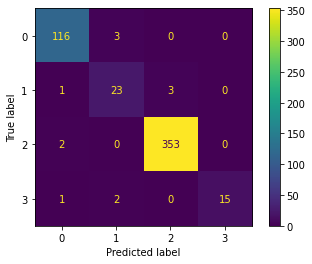

In [10]:
ski_tree = tree.DecisionTreeClassifier()
%time test_classifier(ski_tree, C_X_train, C_X_test, C_y_train, C_y_test)

## Random Forest

Если не ограничивать глубину деревьев решений, то они будут стремиться максимально 
делить тестовые данные, в плоть до максимально чистых листьев. Random Forest стремится 
решить эту проблему: вместо одного дерева будет создаваться лес, причем эти деревья
будет тренироваться случайно - из входных пар `(Особенности, класс)` 
$(X_1, y_1), (X_2, y_2), ..., (X_n, y_n)$ ($n$ пар) для каждого дерева будет 
создаваться независимая случайная выборка с заменами (пары могут повторяться многократно)
и дерево будет тренироваться на ней.

При обучении каждое дерево будет возвращать свой вариант классификации, после чего
результатом будет наиболее частый класс (или среднее значение в случае регрессии).

### Собственная реализация

Первый параметр - количество деревьев в лесу.

Accuracy is 0.775
CPU times: user 6.15 s, sys: 3.64 ms, total: 6.16 s
Wall time: 6.25 s


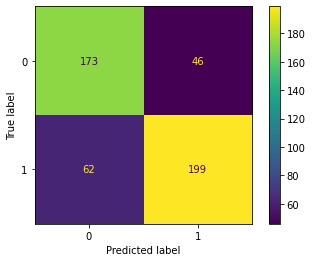

In [11]:
custom_forest = RandomForest(10)
custom_forest.fit = custom_forest.train
%time test_classifier(custom_forest, W_X_train, W_X_test, W_y_train, W_y_test)

Accuracy is 0.9633911368015414
CPU times: user 935 ms, sys: 221 µs, total: 936 ms
Wall time: 960 ms


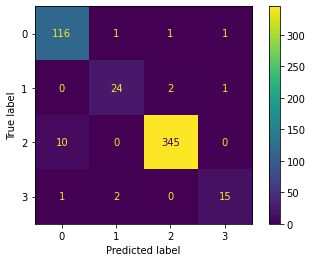

In [12]:
custom_forest = RandomForest(10)
custom_forest.fit = custom_forest.train
%time test_classifier(custom_forest, C_X_train, C_X_test, C_y_train, C_y_test)

Хотя точности примерно одинаковы, скорость значительно упала. Может разница между деревом и лесом
будет заметнее на больших объемах тренировочных данных.

### Реализация `sklearn`

Стандартно, количество деревьев равно 100, но для сравнения они настроены на 10 деревьев:

Accuracy is 0.8104166666666667
CPU times: user 70.2 ms, sys: 29 µs, total: 70.2 ms
Wall time: 68.2 ms


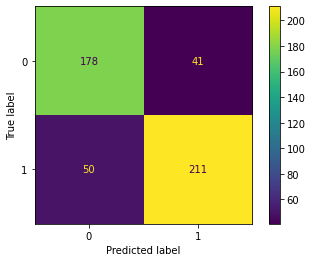

In [15]:
ski_forest = ensemble.RandomForestClassifier(10)
%time test_classifier(ski_forest, W_X_train, W_X_test, W_y_train, W_y_test)

Accuracy is 0.9364161849710982
CPU times: user 68.4 ms, sys: 6.53 ms, total: 75 ms
Wall time: 72.4 ms


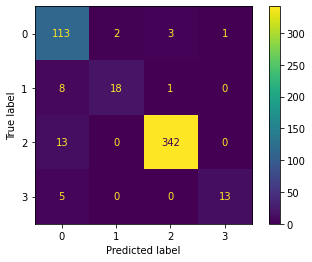

In [16]:
ski_forest = ensemble.RandomForestClassifier(10)
%time test_classifier(ski_forest, C_X_train, C_X_test, C_y_train, C_y_test)

Точность отличается то выше, то ниже, возможно из-за того, как случайно подбираются данные в самой реализации.